# Parameter Stability Across Batches: NCP (nokappa v3) Model

**Goal**: Quantify batch-to-batch stability of $\gamma$ and $\psi$ across 40 independent training batches (10k patients each) in the non-centered parameterization.

**Why this matters**: In the NCP formulation, $\lambda_{ikt} = r_k + \mathbf{g}_i^\top \Gamma_k + \delta_{ikt}$.
- $\Gamma$ (gamma) maps genetic features → signature loadings. It gets strong NLL gradients but has **no explicit prior**.
- $\psi$ maps signatures → disease probabilities (via $\phi = \text{softmax}(\psi)$). It also gets NLL gradients and is anchored by the **same initialization** across batches.
- $\delta$ carries the GP prior and absorbs individual-level residual variation.

The gamma/delta tradeoff means $\gamma$ can vary across batches while total $\lambda$ stays well-determined. $\psi$ has an analogous tradeoff with $\epsilon$, but $\epsilon$ is shared across patients (not per-patient like $\delta$), so the tradeoff is more constrained. The question: does $\psi$ show more stability?

**Comparison**: We also load the centered (nolr) model's $\gamma$ and $\psi$ for reference.

In [ ]:
import torch, numpy as np, pandas as pd, glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats

%matplotlib inline
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'white'

## 1. Load all 40 batches for both models

In [ ]:
def load_all_batches(base_dir, param_location='top'):
    """Load gamma and psi from all checkpoint files in a directory.
    param_location: 'top' for nokappa (gamma/psi at top level),
                    'state_dict' for nolr (inside model_state_dict)"""
    files = sorted(glob.glob(f'{base_dir}/*.pt'))
    gammas, psis = [], []
    for f in files:
        ck = torch.load(f, weights_only=False)
        if param_location == 'top':
            g = ck['gamma']
            p = ck['psi']
        else:
            g = ck['model_state_dict']['gamma']
            p = ck['model_state_dict'].get('psi', ck.get('psi'))
        gammas.append(g.detach().numpy() if isinstance(g, torch.Tensor) else g)
        psis.append(p.detach().numpy() if isinstance(p, torch.Tensor) else p)
    return np.stack(gammas), np.stack(psis), len(files)

NOKAPPA_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_REPARAM_v3_nokappa'
NOLR_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_nolr'

nk_gamma, nk_psi, n_nk = load_all_batches(NOKAPPA_DIR, 'top')
nolr_gamma, nolr_psi, n_nolr = load_all_batches(NOLR_DIR, 'state_dict')

print(f'Nokappa: {n_nk} batches, gamma {nk_gamma.shape}, psi {nk_psi.shape}')
print(f'Nolr:    {n_nolr} batches, gamma {nolr_gamma.shape}, psi {nolr_psi.shape}')

prs_df = pd.read_csv('/Users/sarahurbut/aladynoulli2/prs_names.csv', header=None)
prs_names = list(prs_df.iloc[:, 0].values)
n_prs = len(prs_names)

essentials = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']
clusters = torch.load(sorted(glob.glob(f'{NOKAPPA_DIR}/*.pt'))[0], weights_only=False)['clusters']
K = 20

sig_labels = {}
for k in range(K):
    dis = [disease_names[d] for d in range(len(disease_names)) if clusters[d] == k]
    sig_labels[k] = dis[0].split(',')[0][:25] if dis else f'Sig {k}'
sig_labels[K] = 'Health'
print('\nSignature labels:')
for k in range(K+1):
    print(f'  Sig {k:2d}: {sig_labels[k]}')

Nokappa: 40 batches, gamma (40, 47, 21), psi (40, 21, 348)
Nolr:    40 batches, gamma (40, 47, 21), psi (40, 21, 348)

Signature labels:
  Sig  0: Rheumatic disease of the 
  Sig  1: Other peripheral nerve di
  Sig  2: Benign neoplasm of other 
  Sig  3: Bacterial enteritis
  Sig  4: Septal Deviations/Turbina
  Sig  5: Hypercholesterolemia
  Sig  6: Cancer of bronchus; lung
  Sig  7: Hypothyroidism NOS
  Sig  8: Cervical intraepithelial 
  Sig  9: Degenerative disease of t
  Sig 10: Retinal detachments and d
  Sig 11: Hemiplegia
  Sig 12: Other disorders of the ki
  Sig 13: Cancer of prostate
  Sig 14: Tobacco use disorder
  Sig 15: Type 1 diabetes
  Sig 16: Gram negative septicemia
  Sig 17: Colon cancer
  Sig 18: Peritoneal adhesions (pos
  Sig 19: Viral warts & HPV
  Sig 20: Health


## 2. Gamma stability: NCP vs Centered

For each (PRS, signature) entry, compute the coefficient of variation (CV = std/|mean|) and sign-flip rate across 40 batches.

In [ ]:
def stability_stats(stack, n_features, K):
    """Compute per-entry stability metrics from a (B, P, K+1) stack."""
    sub = stack[:, :n_features, :K]  # PRS x disease sigs only
    m = sub.mean(axis=0)
    s = sub.std(axis=0)
    cv = s / np.maximum(np.abs(m), 1e-8)
    sign_flip = np.zeros_like(m)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            vals = sub[:, i, j]
            sign_flip[i, j] = 1.0 - max((vals > 0).mean(), (vals < 0).mean())
    batch_corrs = [np.corrcoef(sub[b].ravel(), m.ravel())[0,1] for b in range(stack.shape[0])]
    return m, s, cv, sign_flip, np.array(batch_corrs)

nk_g_mean, nk_g_std, nk_g_cv, nk_g_flip, nk_g_corrs = stability_stats(nk_gamma, n_prs, K)
nolr_g_mean, nolr_g_std, nolr_g_cv, nolr_g_flip, nolr_g_corrs = stability_stats(nolr_gamma, n_prs, K)

print('=== GAMMA stability (36 PRS x 20 disease signatures) ===')
print(f'{"":>20s} {"NCP (nokappa)":>15s} {"Centered (nolr)":>15s}')
print(f'{"mean |gamma|":>20s} {np.abs(nk_g_mean).mean():15.4f} {np.abs(nolr_g_mean).mean():15.4f}')
print(f'{"mean batch std":>20s} {nk_g_std.mean():15.4f} {nolr_g_std.mean():15.4f}')
print(f'{"median CV":>20s} {np.median(nk_g_cv):15.2f} {np.median(nolr_g_cv):15.2f}')
print(f'{"mean sign-flip rate":>20s} {nk_g_flip.mean():15.1%} {nolr_g_flip.mean():15.1%}')
print(f'{"batch-to-mean corr":>20s} {nk_g_corrs.mean():15.4f} {nolr_g_corrs.mean():15.4f}')
print(f'{"  (min / max)":>20s} {nk_g_corrs.min():.3f} / {nk_g_corrs.max():.3f}      {nolr_g_corrs.min():.3f} / {nolr_g_corrs.max():.3f}')

=== GAMMA stability (36 PRS x 20 disease signatures) ===
                       NCP (nokappa) Centered (nolr)
        mean |gamma|          0.0648          0.0046
      mean batch std          0.1359          0.0145
           median CV            2.50            5.91
 mean sign-flip rate           30.0%           39.2%
  batch-to-mean corr          0.4794          0.5795
         (min / max) 0.272 / 0.585      0.510 / 0.642


## 3. Psi stability: NCP vs Centered

$\psi$ maps signatures to diseases via $\phi_{kdt} = \sigma(\text{logit\_prev}_{dt} + \psi_{kd} + \epsilon_{kdt})$ where $\sigma$ is the sigmoid (inverse logit). Like $\gamma$, $\psi$ has a tradeoff partner ($\epsilon$, shape $K\!+\!1 \times D \times T$). But there is a key structural difference:

- $\delta$ is **per-patient** ($N \times K\!+\!1 \times T$) — different batches with different patients can find very different $\gamma/\delta$ splits
- $\epsilon$ is **shared across all patients** ($K\!+\!1 \times D \times T$) — the $\psi/\epsilon$ tradeoff is more constrained because $\epsilon$ must work for everyone

Additionally, $\psi$ is anchored by `logit_prev_t` (known population prevalence), constraining its range. So we'd expect $\psi$ to be more stable than $\gamma$.

In [ ]:
def psi_stability_stats(stack):
    """Compute per-entry stability for psi (K+1, D) across batches."""
    m = stack.mean(axis=0)  # (K+1, D)
    s = stack.std(axis=0)
    cv = s / np.maximum(np.abs(m), 1e-8)
    sign_flip = np.zeros_like(m)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            vals = stack[:, i, j]
            sign_flip[i, j] = 1.0 - max((vals > 0).mean(), (vals < 0).mean())
    batch_corrs = [np.corrcoef(stack[b].ravel(), m.ravel())[0,1] for b in range(stack.shape[0])]
    return m, s, cv, sign_flip, np.array(batch_corrs)

nk_p_mean, nk_p_std, nk_p_cv, nk_p_flip, nk_p_corrs = psi_stability_stats(nk_psi)
nolr_p_mean, nolr_p_std, nolr_p_cv, nolr_p_flip, nolr_p_corrs = psi_stability_stats(nolr_psi)

print('=== PSI stability (21 signatures x 348 diseases) ===')
print(f'{"":>20s} {"NCP (nokappa)":>15s} {"Centered (nolr)":>15s}')
print(f'{"mean |psi|":>20s} {np.abs(nk_p_mean).mean():15.4f} {np.abs(nolr_p_mean).mean():15.4f}')
print(f'{"mean batch std":>20s} {nk_p_std.mean():15.4f} {nolr_p_std.mean():15.4f}')
print(f'{"median CV":>20s} {np.median(nk_p_cv):15.2f} {np.median(nolr_p_cv):15.2f}')
print(f'{"mean sign-flip rate":>20s} {nk_p_flip.mean():15.1%} {nolr_p_flip.mean():15.1%}')
print(f'{"batch-to-mean corr":>20s} {nk_p_corrs.mean():15.4f} {nolr_p_corrs.mean():15.4f}')
print(f'{"  (min / max)":>20s} {nk_p_corrs.min():.3f} / {nk_p_corrs.max():.3f}      {nolr_p_corrs.min():.3f} / {nolr_p_corrs.max():.3f}')

=== PSI stability (21 signatures x 348 diseases) ===
                       NCP (nokappa) Centered (nolr)
          mean |psi|          2.2401          2.1118
      mean batch std          0.3780          0.0830
           median CV            0.14            0.01
 mean sign-flip rate            2.4%            1.0%
  batch-to-mean corr          0.9617          0.9710
         (min / max) 0.948 / 0.971      0.966 / 0.976


## 4. Side-by-side comparison: gamma vs psi stability

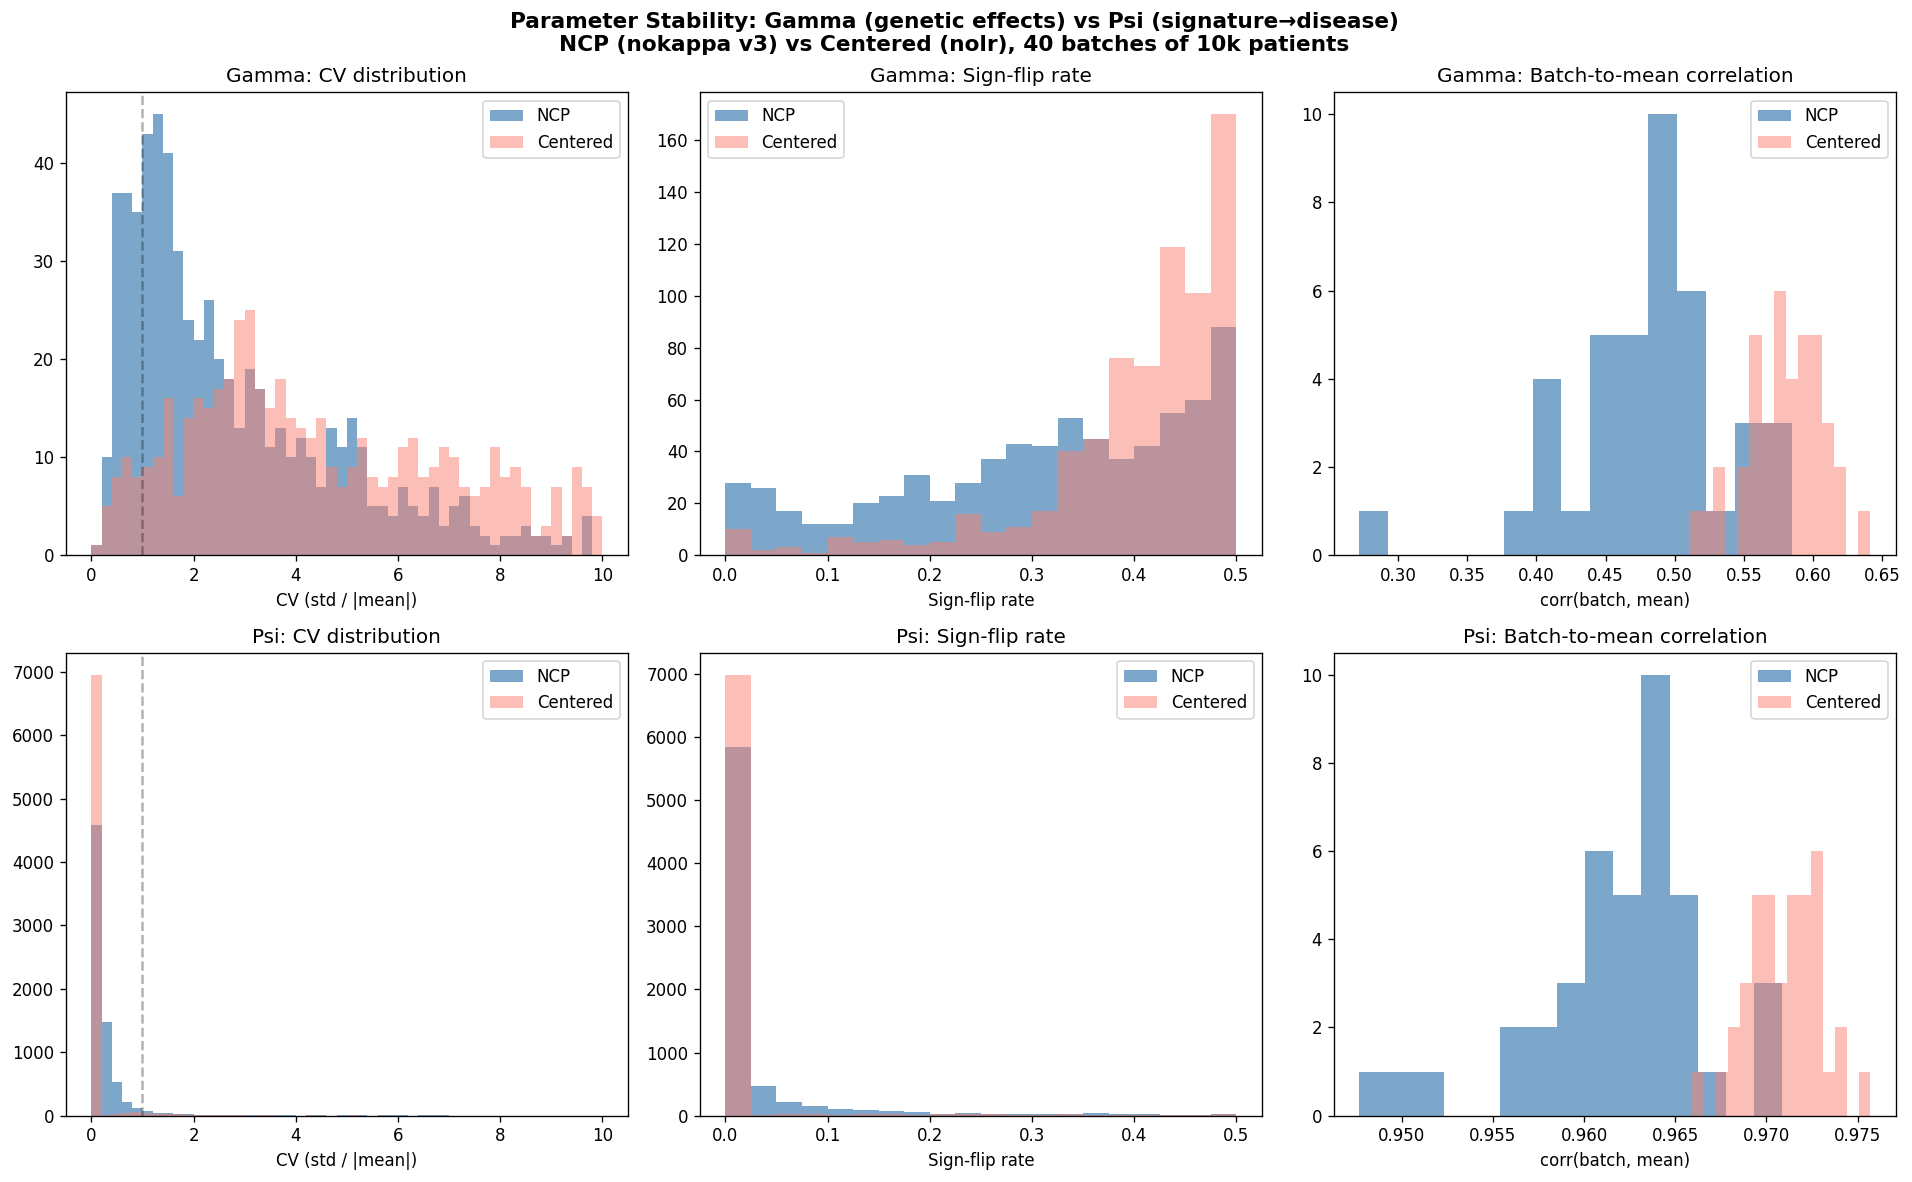

Saved: parameter_stability_gamma_vs_psi.pdf


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Row 0: Gamma
# CV histogram
axes[0, 0].hist(nk_g_cv.ravel(), bins=50, alpha=0.7, label='NCP', color='steelblue', range=(0, 10))
axes[0, 0].hist(nolr_g_cv.ravel(), bins=50, alpha=0.5, label='Centered', color='salmon', range=(0, 10))
axes[0, 0].set_xlabel('CV (std / |mean|)')
axes[0, 0].set_title('Gamma: CV distribution')
axes[0, 0].legend()
axes[0, 0].axvline(1, color='k', ls='--', alpha=0.3)

# Sign-flip rate histogram
axes[0, 1].hist(nk_g_flip.ravel(), bins=20, alpha=0.7, label='NCP', color='steelblue', range=(0, 0.5))
axes[0, 1].hist(nolr_g_flip.ravel(), bins=20, alpha=0.5, label='Centered', color='salmon', range=(0, 0.5))
axes[0, 1].set_xlabel('Sign-flip rate')
axes[0, 1].set_title('Gamma: Sign-flip rate')
axes[0, 1].legend()

# Batch-to-mean correlation
axes[0, 2].hist(nk_g_corrs, bins=15, alpha=0.7, label='NCP', color='steelblue')
axes[0, 2].hist(nolr_g_corrs, bins=15, alpha=0.5, label='Centered', color='salmon')
axes[0, 2].set_xlabel('corr(batch, mean)')
axes[0, 2].set_title('Gamma: Batch-to-mean correlation')
axes[0, 2].legend()

# Row 1: Psi
axes[1, 0].hist(nk_p_cv.ravel(), bins=50, alpha=0.7, label='NCP', color='steelblue', range=(0, 10))
axes[1, 0].hist(nolr_p_cv.ravel(), bins=50, alpha=0.5, label='Centered', color='salmon', range=(0, 10))
axes[1, 0].set_xlabel('CV (std / |mean|)')
axes[1, 0].set_title('Psi: CV distribution')
axes[1, 0].legend()
axes[1, 0].axvline(1, color='k', ls='--', alpha=0.3)

axes[1, 1].hist(nk_p_flip.ravel(), bins=20, alpha=0.7, label='NCP', color='steelblue', range=(0, 0.5))
axes[1, 1].hist(nolr_p_flip.ravel(), bins=20, alpha=0.5, label='Centered', color='salmon', range=(0, 0.5))
axes[1, 1].set_xlabel('Sign-flip rate')
axes[1, 1].set_title('Psi: Sign-flip rate')
axes[1, 1].legend()

axes[1, 2].hist(nk_p_corrs, bins=15, alpha=0.7, label='NCP', color='steelblue')
axes[1, 2].hist(nolr_p_corrs, bins=15, alpha=0.5, label='Centered', color='salmon')
axes[1, 2].set_xlabel('corr(batch, mean)')
axes[1, 2].set_title('Psi: Batch-to-mean correlation')
axes[1, 2].legend()

plt.suptitle('Parameter Stability: Gamma (genetic effects) vs Psi (signature→disease)\n'
             'NCP (nokappa v3) vs Centered (nolr), 40 batches of 10k patients',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/parameter_stability_gamma_vs_psi.pdf',
            dpi=300, bbox_inches='tight')
plt.show()
print('Saved: parameter_stability_gamma_vs_psi.pdf')

## 5. Gamma stability by signal strength

Is the instability concentrated in weak signals (noise floor) or does it affect the strong biological signals too?

In [ ]:
bins = [(0, 0.05, 'Weak (|mean|<0.05)'),
        (0.05, 0.15, 'Moderate (0.05-0.15)'),
        (0.15, 0.5, 'Strong (0.15-0.50)'),
        (0.5, 999, 'Very strong (>0.50)')]

print('=== NCP GAMMA: stability by signal strength ===')
print(f'{"Bin":>25s} {"n":>5s} {"med CV":>8s} {"sign-flip":>10s} {"mean std":>10s}')
print('-'*65)
for lo, hi, label in bins:
    mask = (np.abs(nk_g_mean) >= lo) & (np.abs(nk_g_mean) < hi)
    if mask.sum() > 0:
        print(f'{label:>25s} {mask.sum():5d} {np.median(nk_g_cv[mask]):8.2f} '
              f'{nk_g_flip[mask].mean():10.1%} {nk_g_std[mask].mean():10.4f}')

print()
print('=== NCP PSI: stability by signal strength ===')
print(f'{"Bin":>25s} {"n":>5s} {"med CV":>8s} {"sign-flip":>10s} {"mean std":>10s}')
print('-'*65)
for lo, hi, label in bins:
    mask = (np.abs(nk_p_mean) >= lo) & (np.abs(nk_p_mean) < hi)
    if mask.sum() > 0:
        print(f'{label:>25s} {mask.sum():5d} {np.median(nk_p_cv[mask]):8.2f} '
              f'{nk_p_flip[mask].mean():10.1%} {nk_p_std[mask].mean():10.4f}')

=== NCP GAMMA: stability by signal strength ===
                      Bin     n   med CV  sign-flip   mean std
-----------------------------------------------------------------
       Weak (|mean|<0.05)   384     4.82      39.4%     0.1304
     Moderate (0.05-0.15)   268     1.35      22.6%     0.1443
       Strong (0.15-0.50)    66     0.57       5.7%     0.1296
      Very strong (>0.50)     2     0.42       1.3%     0.2718

=== NCP PSI: stability by signal strength ===
                      Bin     n   med CV  sign-flip   mean std
-----------------------------------------------------------------
       Weak (|mean|<0.05)    19    16.05      44.9%     0.5412
     Moderate (0.05-0.15)    64     5.14      39.9%     0.4987
       Strong (0.15-0.50)   260     1.27      21.5%     0.5003
      Very strong (>0.50)  6965     0.13       1.2%     0.3719


## 6. Key biological signals: gamma stability

Check the specific PRS→signature associations that matter most.

In [ ]:
key_pairs = [
    ('T2D', 15, 'DM'),
    ('CAD', 5, 'Ischemic CVD'),
    ('T1D', 15, 'DM'),
    ('RA', 1, 'Arthropathy'),
    ('POAG', 10, 'Retinal'),
    ('AAM', 8, 'GynOnc'),
    ('Breast_Cancer', 8, 'GynOnc'),
    ('LDL', 5, 'Ischemic CVD'),
    ('CAD', 11, 'Stroke'),
    ('CAD', 7, 'Metabolic'),
    ('T2D', 7, 'Metabolic'),
    ('BMI', 7, 'Metabolic'),
]

print(f'{"PRS -> Sig":>25s}  {"NCP mean":>9s} {"NCP std":>9s} {"CV":>6s} {"sign":>6s}  '
      f'{"nolr mean":>9s} {"nolr std":>9s} {"CV":>6s}')
print('-'*100)
for prs_name, sig_k, sig_desc in key_pairs:
    if prs_name not in prs_names:
        continue
    pidx = prs_names.index(prs_name)
    nk_vals = nk_gamma[:, pidx, sig_k]
    nolr_vals = nolr_gamma[:, pidx, sig_k]
    nk_m, nk_s = nk_vals.mean(), nk_vals.std()
    nolr_m, nolr_s = nolr_vals.mean(), nolr_vals.std()
    nk_cv = nk_s / max(abs(nk_m), 1e-8)
    nolr_cv = nolr_s / max(abs(nolr_m), 1e-8)
    sign = 'YES' if (nk_vals > 0).all() or (nk_vals < 0).all() else 'mixed'
    label = f'{prs_name}->{sig_k}({sig_desc})'
    print(f'{label:>25s}  {nk_m:9.4f} {nk_s:9.4f} {nk_cv:6.2f} {sign:>6s}  '
          f'{nolr_m:9.4f} {nolr_s:9.4f} {nolr_cv:6.2f}')

               PRS -> Sig   NCP mean   NCP std     CV   sign  nolr mean  nolr std     CV
----------------------------------------------------------------------------------------------------
              T2D->15(DM)     1.1791    0.1287   0.11    YES     0.1539    0.0167   0.11
     CAD->5(Ischemic CVD)     0.2656    0.0806   0.30    YES     0.1534    0.0356   0.23
              T1D->15(DM)     0.1372    0.1166   0.85  mixed     0.0251    0.0188   0.75
       RA->1(Arthropathy)     0.1063    0.0748   0.70  mixed     0.0135    0.0181   1.34
        POAG->10(Retinal)     0.1507    0.0907   0.60  mixed     0.0299    0.0162   0.54
           AAM->8(GynOnc)     0.0128    0.0781   6.12  mixed     0.0119    0.0095   0.80
          CAD->11(Stroke)    -0.1397    0.3832   2.74  mixed    -0.0026    0.0131   4.94
        CAD->7(Metabolic)     0.0770    0.0743   0.96  mixed     0.0174    0.0260   1.49
        T2D->7(Metabolic)     0.1735    0.0993   0.57  mixed     0.0206    0.0171   0.83
        B

### 6b. Boxplot: gamma distribution across 40 batches (key PRS → signature pairs)

For each key PRS→signature pair, show the distribution of gamma values across all 40 training batches. Stable signals should have tight boxes on one side of zero; unstable ones will span zero.

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65465/2732880500.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(plot_data_nk, patch_artist=True, labels=labels,
/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_65465/2732880500.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(plot_data_nolr, patch_artist=True, labels=labels,


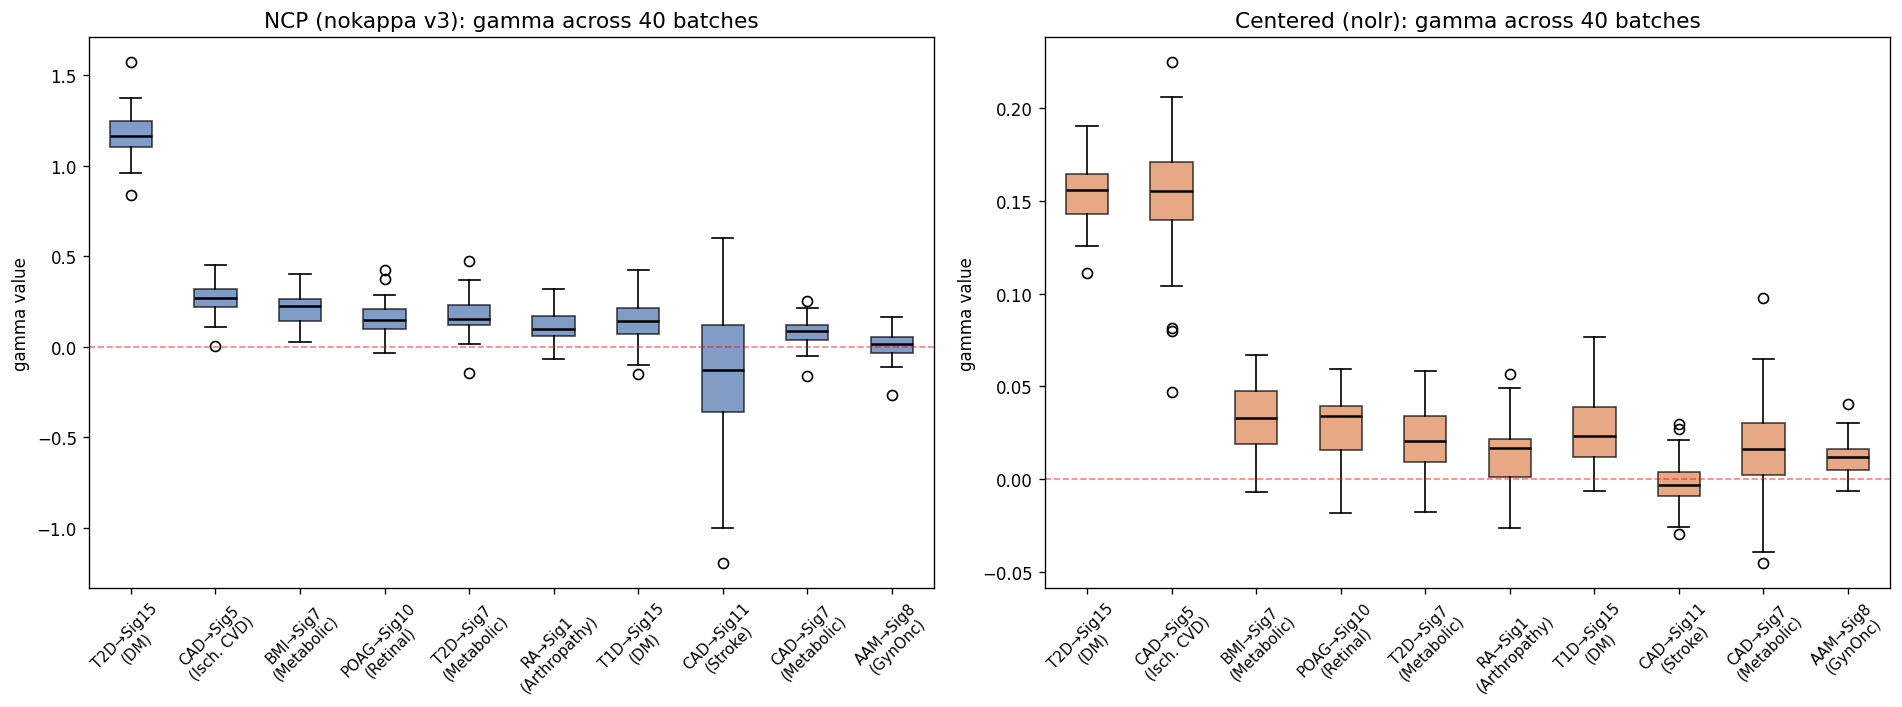

Saved → claudefile/gamma_boxplot_40batches.pdf


In [ ]:
key_pairs_for_plot = [
    ('T2D', 15, 'DM'), ('CAD', 5, 'Isch. CVD'), ('BMI', 7, 'Metabolic'),
    ('POAG', 10, 'Retinal'), ('T2D', 7, 'Metabolic'), ('RA', 1, 'Arthropathy'),
    ('T1D', 15, 'DM'), ('CAD', 11, 'Stroke'), ('CAD', 7, 'Metabolic'),
    ('AAM', 8, 'GynOnc'),
]

plot_data_nk, plot_data_nolr, labels = [], [], []
for prs_name, sig_k, sig_desc in key_pairs_for_plot:
    if prs_name not in prs_names:
        continue
    pidx = prs_names.index(prs_name)
    plot_data_nk.append(nk_gamma[:, pidx, sig_k])
    plot_data_nolr.append(nolr_gamma[:, pidx, sig_k])
    labels.append(f'{prs_name}→Sig{sig_k}\n({sig_desc})')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

bp1 = axes[0].boxplot(plot_data_nk, patch_artist=True, labels=labels,
                       medianprops=dict(color='black', linewidth=1.5))
for patch in bp1['boxes']:
    patch.set_facecolor('#4C72B0')
    patch.set_alpha(0.7)
axes[0].axhline(0, color='red', ls='--', alpha=0.5, lw=1)
axes[0].set_title('NCP (nokappa v3): gamma across 40 batches', fontsize=13)
axes[0].set_ylabel('gamma value')
axes[0].tick_params(axis='x', rotation=45, labelsize=9)

bp2 = axes[1].boxplot(plot_data_nolr, patch_artist=True, labels=labels,
                       medianprops=dict(color='black', linewidth=1.5))
for patch in bp2['boxes']:
    patch.set_facecolor('#DD8452')
    patch.set_alpha(0.7)
axes[1].axhline(0, color='red', ls='--', alpha=0.5, lw=1)
axes[1].set_title('Centered (nolr): gamma across 40 batches', fontsize=13)
axes[1].set_ylabel('gamma value')
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/gamma_boxplot_40batches.pdf', bbox_inches='tight')
plt.show()
print("Saved → claudefile/gamma_boxplot_40batches.pdf")

### 6c. Psi switches from initialization to final (pooled)

Which diseases' maximum-posterior signature changed from initialization to the trained model? We load the initial psi, compute the argmax signature per disease, and compare to the pooled final psi. Diseases that "switched" their dominant signature are listed.

Psi switches from initialization to final (pooled NCP):
  9 / 348 diseases changed their max-psi signature

Disease                                         Init Sig  Final Sig    |Δpsi|
--------------------------------------------------------------------------------
Pyelonephritis                                 12 (Other disorders of t) →  16 (Gram negative septic)     1.269
Urinary incontinence                           13 (Cancer of prostate) →   8 (Cervical intraepithe)     1.130
Hydronephrosis                                 12 (Other disorders of t) →  16 (Gram negative septic)     0.519
Other disorders of biliary tract               18 (Peritoneal adhesions) →  16 (Gram negative septic)     0.342
Acute pancreatitis                             18 (Peritoneal adhesions) →  16 (Gram negative septic)     0.308
Peritoneal adhesions (postoperative) (postin   18 (Peritoneal adhesions) →  16 (Gram negative septic)     0.273
Other disorders of the kidney and ureters      12 (Other disord

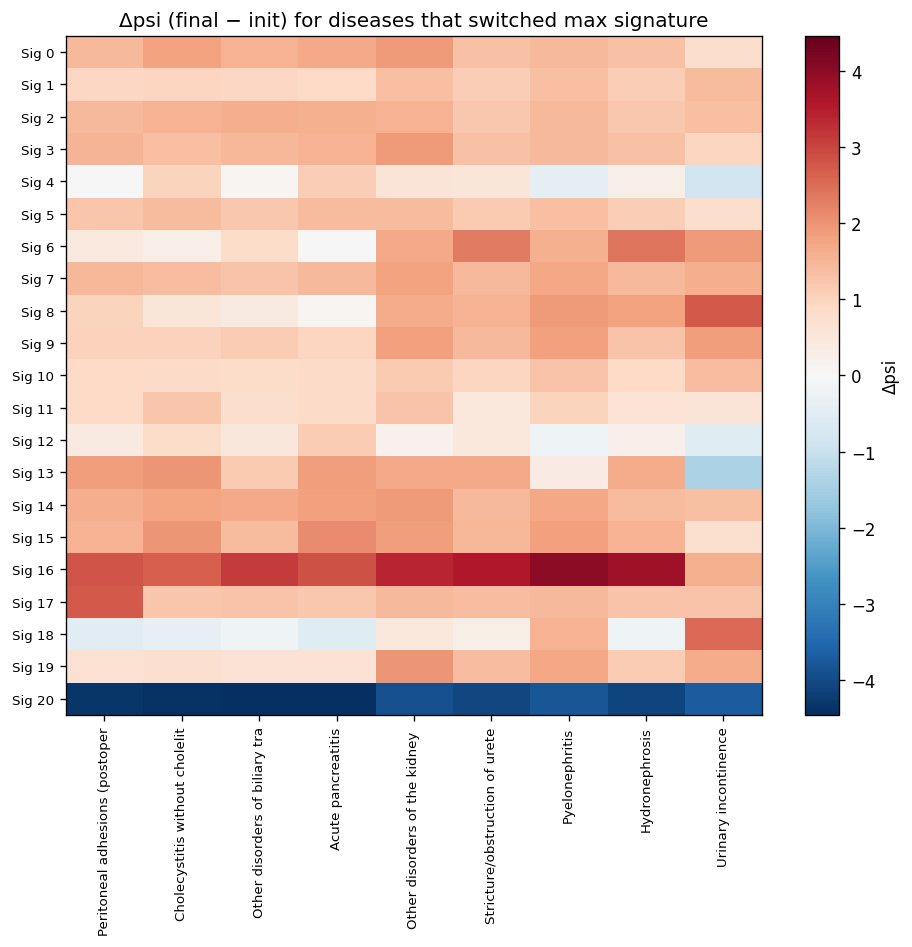


Saved → claudefile/psi_switches_from_init.pdf


In [ ]:
initial_psi = torch.load(
    '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt',
    weights_only=False
).numpy()  # (K+1, D) = (20, 348) — note: might be (21, 348), we'll check

if initial_psi.shape[0] == 20:
    init_psi_full = np.zeros((21, initial_psi.shape[1]))
    init_psi_full[:20, :] = initial_psi
    initial_psi = init_psi_full

nk_psi_pooled = nk_psi.mean(axis=0)  # (21, 348)

init_argmax = initial_psi.argmax(axis=0)  # (348,)
final_argmax = nk_psi_pooled.argmax(axis=0)  # (348,)

switched = init_argmax != final_argmax
n_switched = switched.sum()
n_total = len(init_argmax)

print(f"Psi switches from initialization to final (pooled NCP):")
print(f"  {n_switched} / {n_total} diseases changed their max-psi signature\n")

if n_switched > 0:
    print(f"{'Disease':<45s} {'Init Sig':>10s} {'Final Sig':>10s}  {'|Δpsi|':>8s}")
    print('-' * 80)
    switch_rows = []
    for d in range(n_total):
        if switched[d]:
            dname = disease_names[d] if d < len(disease_names) else f'Disease {d}'
            dpsi = abs(nk_psi_pooled[final_argmax[d], d] - nk_psi_pooled[init_argmax[d], d])
            switch_rows.append((dname, init_argmax[d], final_argmax[d], dpsi))
    switch_rows.sort(key=lambda x: -x[3])
    for dname, isig, fsig, dpsi in switch_rows:
        ilab = sig_labels.get(isig, f'Sig {isig}')[:20]
        flab = sig_labels.get(fsig, f'Sig {fsig}')[:20]
        print(f"{dname[:44]:<45s} {isig:>3d} ({ilab}) → {fsig:>3d} ({flab})  {dpsi:8.3f}")

# Visualization: heatmap of |psi_final - psi_init| for switched diseases
if n_switched > 0 and n_switched <= 40:
    switch_idx = np.where(switched)[0]
    delta_psi = nk_psi_pooled[:, switch_idx] - initial_psi[:, switch_idx]

    fig, ax = plt.subplots(figsize=(max(8, n_switched * 0.5), 8))
    d_names_sw = [disease_names[i][:30] if i < len(disease_names) else f'D{i}' for i in switch_idx]
    s_names = [f"Sig {k}" for k in range(21)]

    im = ax.imshow(delta_psi, aspect='auto', cmap='RdBu_r',
                   vmin=-np.abs(delta_psi).max(), vmax=np.abs(delta_psi).max())
    ax.set_xticks(range(len(d_names_sw)))
    ax.set_xticklabels(d_names_sw, rotation=90, fontsize=8)
    ax.set_yticks(range(21))
    ax.set_yticklabels(s_names, fontsize=8)
    ax.set_title('Δpsi (final − init) for diseases that switched max signature', fontsize=12)
    plt.colorbar(im, ax=ax, label='Δpsi')
    plt.tight_layout()
    plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/psi_switches_from_init.pdf', bbox_inches='tight')
    plt.show()
    print("\nSaved → claudefile/psi_switches_from_init.pdf")
elif n_switched > 40:
    print(f"\n(Too many switches ({n_switched}) to show heatmap — showing top 30 by |Δpsi|)")
    switch_idx_all = np.where(switched)[0]
    dpsi_all = [abs(nk_psi_pooled[final_argmax[d], d] - nk_psi_pooled[init_argmax[d], d]) for d in switch_idx_all]
    top30 = np.argsort(dpsi_all)[-30:]
    switch_idx = switch_idx_all[top30]
    delta_psi = nk_psi_pooled[:, switch_idx] - initial_psi[:, switch_idx]

    fig, ax = plt.subplots(figsize=(16, 8))
    d_names_sw = [disease_names[i][:30] if i < len(disease_names) else f'D{i}' for i in switch_idx]
    im = ax.imshow(delta_psi, aspect='auto', cmap='RdBu_r',
                   vmin=-np.abs(delta_psi).max(), vmax=np.abs(delta_psi).max())
    ax.set_xticks(range(len(d_names_sw)))
    ax.set_xticklabels(d_names_sw, rotation=90, fontsize=7)
    ax.set_yticks(range(21))
    ax.set_yticklabels([f"Sig {k}" for k in range(21)], fontsize=8)
    ax.set_title('Δpsi (final − init): top 30 switched diseases by |Δpsi|', fontsize=12)
    plt.colorbar(im, ax=ax, label='Δpsi')
    plt.tight_layout()
    plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/psi_switches_from_init.pdf', bbox_inches='tight')
    plt.show()
    print("\nSaved → claudefile/psi_switches_from_init.pdf")

## 7. Phi stability (sigmoid of logit_prev + psi)

The model computes $\phi_{kdt} = \sigma(\text{logit\_prev}_{dt} + \psi_{kd} + \epsilon_{kdt})$. Without epsilon (which is per-batch), we can check the **mean phi** stability: $\bar{\phi}_{kd} = \sigma(\text{logit\_prev}_{dt} + \psi_{kd})$. Since sigmoid is monotonic, psi stability directly implies phi stability.

In [ ]:
from scipy.special import expit as sigmoid

# Load logit_prev_t (shared baseline across all batches)
logit_prev_t = torch.load(sorted(glob.glob(f'{NOKAPPA_DIR}/*.pt'))[0],
                          weights_only=False)['logit_prevalence_t'].numpy()  # (D, T)
print(f'logit_prev_t shape: {logit_prev_t.shape}')

def compute_mean_phi(psi_stack, logit_prev_t):
    """Compute mean phi = sigmoid(logit_prev + psi) for each batch.
    psi: (B, K+1, D), logit_prev: (D, T) -> phi: (B, K+1, D, T)"""
    logit = psi_stack[:, :, :, np.newaxis] + logit_prev_t[np.newaxis, np.newaxis, :, :]
    return sigmoid(logit)

nk_phi = compute_mean_phi(nk_psi, logit_prev_t)
nolr_phi = compute_mean_phi(nolr_psi, logit_prev_t)
print(f'nk_phi shape: {nk_phi.shape}')

nk_phi_mean = nk_phi.mean(axis=0)
nk_phi_std = nk_phi.std(axis=0)
nolr_phi_mean = nolr_phi.mean(axis=0)
nolr_phi_std = nolr_phi.std(axis=0)

nk_phi_corrs = [np.corrcoef(nk_phi[b].ravel(), nk_phi_mean.ravel())[0,1] for b in range(nk_phi.shape[0])]
nolr_phi_corrs = [np.corrcoef(nolr_phi[b].ravel(), nolr_phi_mean.ravel())[0,1] for b in range(nolr_phi.shape[0])]

print('\n=== MEAN PHI = sigmoid(logit_prev + psi) stability ===')
print(f'{"":>20s} {"NCP":>15s} {"Centered":>15s}')
print(f'{"mean phi":>20s} {nk_phi_mean.mean():15.4f} {nolr_phi_mean.mean():15.4f}')
print(f'{"mean batch std":>20s} {nk_phi_std.mean():15.6f} {nolr_phi_std.mean():15.6f}')
print(f'{"batch-to-mean corr":>20s} {np.mean(nk_phi_corrs):15.4f} {np.mean(nolr_phi_corrs):15.4f}')
print(f'{"  (min / max)":>20s} {min(nk_phi_corrs):.4f} / {max(nk_phi_corrs):.4f}      '
      f'{min(nolr_phi_corrs):.4f} / {max(nolr_phi_corrs):.4f}')

logit_prev_t shape: (348, 52)
nk_phi shape: (40, 21, 348, 52)

=== MEAN PHI = sigmoid(logit_prev + psi) stability ===
                                 NCP        Centered
            mean phi          0.0008          0.0002
      mean batch std        0.000107        0.000160
  batch-to-mean corr          0.9970          0.7485
         (min / max) 0.9929 / 0.9992      0.5833 / 0.8785


## 8. Heatmap: batch-to-batch std for gamma (PRS only)

Visualize where the instability lives in the gamma matrix.

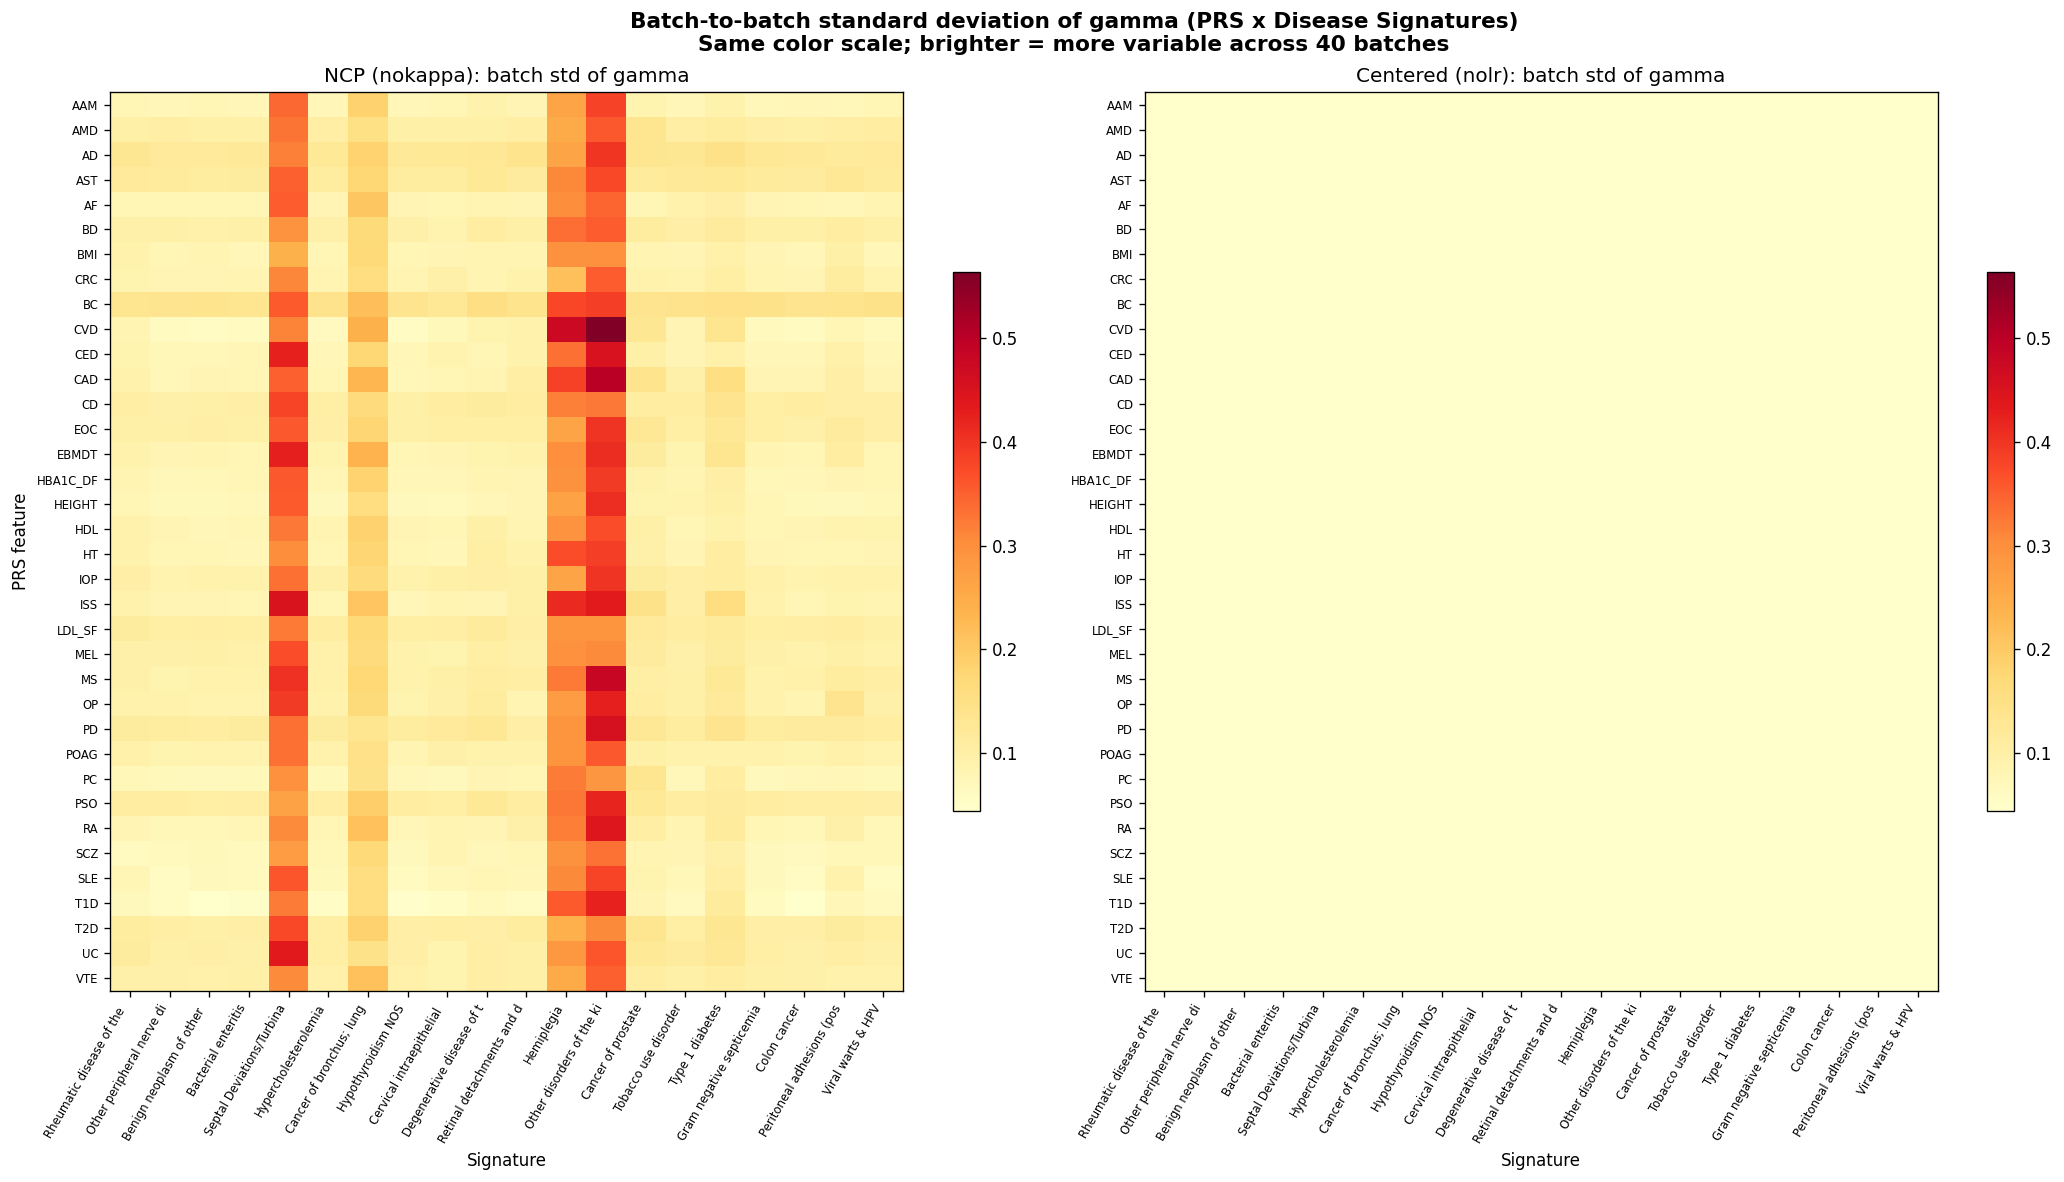

Saved: gamma_std_heatmap_ncp_vs_centered.pdf


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

sig_label_list = [sig_labels.get(k, f'Sig {k}') for k in range(K)]

im0 = axes[0].imshow(nk_g_std, aspect='auto', cmap='YlOrRd')
axes[0].set_title('NCP (nokappa): batch std of gamma', fontsize=12)
axes[0].set_xlabel('Signature')
axes[0].set_ylabel('PRS feature')
axes[0].set_xticks(range(K))
axes[0].set_xticklabels(sig_label_list, rotation=60, ha='right', fontsize=7)
axes[0].set_yticks(range(n_prs))
axes[0].set_yticklabels(prs_names, fontsize=7)
plt.colorbar(im0, ax=axes[0], shrink=0.6)

im1 = axes[1].imshow(nolr_g_std, aspect='auto', cmap='YlOrRd',
                      vmin=im0.get_clim()[0], vmax=im0.get_clim()[1])
axes[1].set_title('Centered (nolr): batch std of gamma', fontsize=12)
axes[1].set_xlabel('Signature')
axes[1].set_xticks(range(K))
axes[1].set_xticklabels(sig_label_list, rotation=60, ha='right', fontsize=7)
axes[1].set_yticks(range(n_prs))
axes[1].set_yticklabels(prs_names, fontsize=7)
plt.colorbar(im1, ax=axes[1], shrink=0.6)

plt.suptitle('Batch-to-batch standard deviation of gamma (PRS x Disease Signatures)\n'
             'Same color scale; brighter = more variable across 40 batches',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('/Users/sarahurbut/aladynoulli2/claudefile/gamma_std_heatmap_ncp_vs_centered.pdf',
            dpi=300, bbox_inches='tight')
plt.show()
print('Saved: gamma_std_heatmap_ncp_vs_centered.pdf')

## 9. Interpretive Summary

### Why gamma varies across batches in the NCP model

In the non-centered parameterization:
$$\lambda_{ikt} = r_k + \mathbf{g}_i^\top \Gamma_k + \delta_{ikt}$$

- $\Gamma$ gets **strong NLL gradients** (flows through forward pass)
- $\Gamma$ has **no explicit prior** — it is unconstrained
- $\delta$ has the GP prior (weight $W = 10^{-4}$)

The **gamma/delta tradeoff**: for any shift $\Gamma_k \to \Gamma_k + c$, the model can compensate with $\delta_{ikt} \to \delta_{ikt} - \mathbf{g}_i^\top c$. This means the *split* between gamma and delta is not uniquely determined — only the total $\lambda$ is. Different batches of patients (different $\mathbf{g}_i$ distributions) find different optimal splits.

$\psi$ has an analogous tradeoff partner ($\epsilon$, shape $K\!+\!1 \times D \times T$), but $\epsilon$ is **shared across all patients** — unlike $\delta$ which is per-patient ($N \times K\!+\!1 \times T$). This means the $\psi/\epsilon$ split is more constrained: $\epsilon$ must work for all 10k patients simultaneously. Additionally, $\psi$ is anchored by `logit_prev_t` (the known population prevalence). If $\psi$ is more stable than $\gamma$, it confirms that the gamma instability is driven by the **per-patient** nature of the $\gamma/\delta$ tradeoff, not a general optimizer problem.

### Gamma IS recoverable — the simulation proves it

The parameter recovery simulation (`parameter_recovery_simulation.ipynb`) showed that the NCP model recovers $\gamma$ with $r = 0.954$ against ground truth, vs $r = 0.796$ for centered. The NCP gives $\gamma$ ~1900x more gradient signal. So $\gamma$ is **well-estimated** within each batch — the batch-to-batch variability is **sampling variability** (different 10k patients → different optimal $\gamma$), not estimation failure.

### Prediction benefits from both components

The NCP model outperforms centered in holdout because:
1. **Between genetic strata**: $\mathbf{g}_i^\top \Gamma_k$ provides a genetically-informed prior mean, giving different starting points for high-risk vs low-risk patients
2. **Within strata**: $\delta$ captures individual residual variation

The centered model had to do both jobs with a single $\lambda$, without direct NLL gradients on $\Gamma$.

### Pooling IS regularization

Averaging $\gamma$ across $B$ batches reduces variance by $\sqrt{B}$. The paper's `gamma_associations.csv` used the 40-batch average — this is effectively a regularized (shrunk) estimate. For prediction, pooling stabilizes the population-level genetic effects, freeing $\delta$ to focus on individual-level signal rather than compensating for batch-specific $\gamma$ noise. An explicit L2 prior on $\gamma$ during training would achieve a similar effect within a single batch.

### Why slopes are still identifiable despite gamma-level variability

The $\gamma/\delta$ tradeoff is in the *level* (constant shift). Genetic slopes ($\Gamma_{\text{slope}}$) introduce a *time-varying* degree of freedom that cannot be absorbed by a constant gamma shift. The simulation (`genetic_slope_recovery.ipynb`) validated that the two-phase training procedure recovers slopes with $r \approx 0.86$–$0.91$, even from imperfect initialization.